## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [472]:
import re

# to handle datasets
import pandas as pd
import numpy as np
from sklearn.impute import MissingIndicator

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [514]:
# load the data - it is available open source and online

data = pd.read_csv('phpMYEkMl.csv')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [515]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [516]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [517]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [518]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [519]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [520]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [521]:
target = 'survived'

In [522]:
vars_num = [num for num in data.columns if data[num].dtypes!='O' and num!=target]
vars_cat = data.select_dtypes('O').columns

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [523]:
# first in numerical variables

data[vars_num].isnull().sum()


pclass      0
age       263
sibsp       0
parch       0
fare        1
dtype: int64

In [524]:
# now in categorical variables

data[vars_cat].isnull().sum()


sex            0
cabin       1014
embarked       2
title          0
dtype: int64

### Determine cardinality of categorical variables

In [525]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

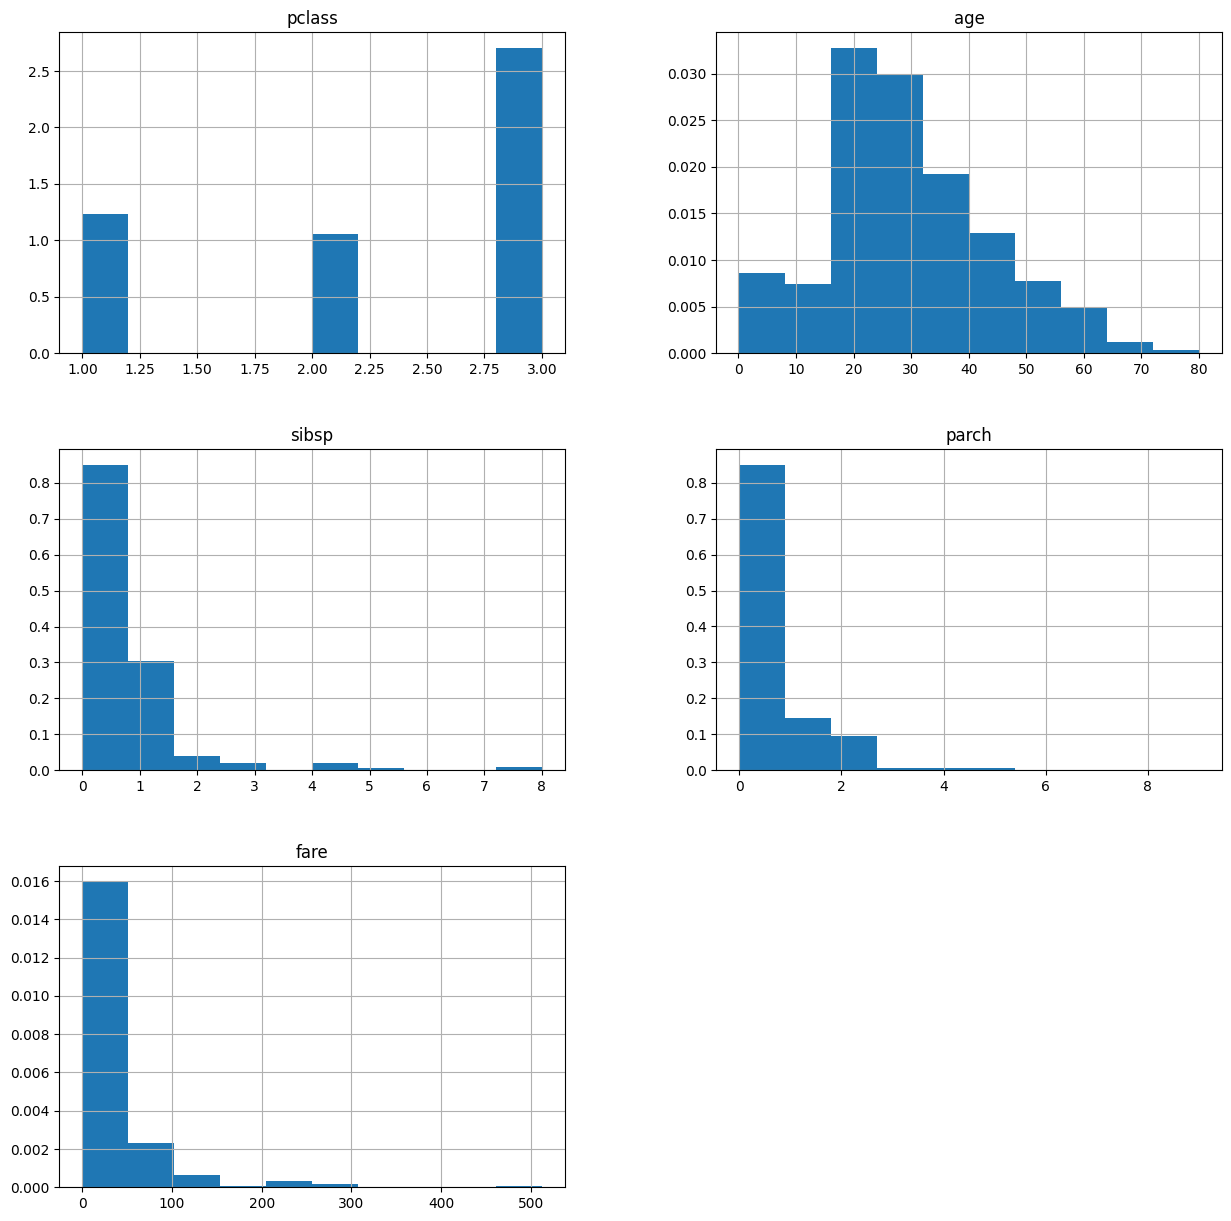

In [526]:
data[vars_num].hist(density=True,figsize=(15,15))
plt.ylabel('category')
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [527]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [528]:
X_train['cabin'] = data['cabin'].str[0]
X_test['cabin'] = data['cabin'].str[0]

X_train['cabin']

1118    NaN
44        E
1072    NaN
1130    NaN
574     NaN
       ... 
763     NaN
835     NaN
1216    NaN
559     NaN
684     NaN
Name: cabin, Length: 1047, dtype: object

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [529]:
X_train.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked',
       'title'],
      dtype='object')

In [531]:
for var in ['age','fare']:
    
    X_train[var+ 'NA'] = np.where(X_train[var].isnull(),1,0)
    X_test[var+'NA'] = np.where(X_test[var].isnull(),1,0)
    
    median_val = X_train[var].median()
    
    X_train[var].fillna(median_val, inplace=True)
    X_test[var].fillna(median_val, inplace=True)
    
X_train [['age','fare']].isnull().sum()

age     0
fare    0
dtype: int64

In [532]:
X_train[vars_num].fillna(data.median())
X_test[vars_num].fillna(data.median())

/var/folders/wj/6hd4mjtd6mq8k1sqmpjzysyc0000gn/T/ipykernel_26213/2377911690.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_train[vars_num].fillna(data.median())
/var/folders/wj/6hd4mjtd6mq8k1sqmpjzysyc0000gn/T/ipykernel_26213/2377911690.py:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_test[vars_num].fillna(data.median())


,pclass,age,sibsp,parch,fare
1139,3,38.0,0,0,7.8958
533,2,21.0,0,1,21.0000
459,2,42.0,1,0,27.0000
1150,3,28.0,0,0,14.5000
393,2,25.0,0,0,31.5000
...,...,...,...,...,...
753,3,22.0,0,0,8.0500
1052,3,28.0,0,0,7.8958
426,2,30.0,0,0,13.0000
554,2,26.0,0,0,13.0000


### Replace Missing data in categorical variables with the string **Missing**

In [533]:
X_train[vars_cat] = X_train[vars_cat].fillna('Missing')
X_test[vars_cat] = X_test[vars_cat].fillna('Missing')

In [534]:
X_train[vars_cat]
X_test[vars_cat]

,sex,cabin,embarked,title
1139,male,Missing,S,Mr
533,female,Missing,S,Miss
459,male,Missing,S,Mr
1150,male,Missing,S,Mr
393,male,Missing,S,Mr
...,...,...,...,...
753,male,Missing,S,Mr
1052,male,Missing,S,Mr
426,male,Missing,S,Mr
554,male,Missing,S,Mr


In [535]:
X_train.isnull().sum()

pclass            0
sex               0
age               0
sibsp             0
parch             0
fare              0
cabin             0
embarked          0
title             0
pclass_missing    0
age_missing       0
sibsp_missing     0
parch_missing     0
fare_missing      0
ageNA             0
fareNA            0
dtype: int64

In [536]:
X_train['age'].fillna("0")

1118    25.0000
44      41.0000
1072    28.0000
1130    18.0000
574     29.0000
         ...   
763      0.1667
835     28.0000
1216    28.0000
559     20.0000
684     32.0000
Name: age, Length: 1047, dtype: float64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [537]:
for col in vars_cat:
    counts = X_train[col].value_counts(normalize=True)
    rare_labels = counts[counts < 0.05].index.tolist()
    X_train[col] = np.where(X_train[col].isin(rare_labels), 'None', X_train[col])
    X_test[col] = np.where(X_test[col].isin(rare_labels), 'None', X_test[col])
print(X_train)

      pclass     sex      age  sibsp  parch      fare    cabin embarked title  \
1118       3    male  25.0000      0      0    7.9250  Missing        S    Mr   
44         1  female  41.0000      0      0  134.5000     None        C  Miss   
1072       3    male  28.0000      0      0    7.7333  Missing        Q    Mr   
1130       3  female  18.0000      0      0    7.7750  Missing        S  Miss   
574        2    male  29.0000      1      0   21.0000  Missing        S    Mr   
...      ...     ...      ...    ...    ...       ...      ...      ...   ...   
763        3  female   0.1667      1      2   20.5750  Missing        S  Miss   
835        3    male  28.0000      0      0    8.0500  Missing        S    Mr   
1216       3  female  28.0000      0      0    7.7333  Missing        Q  Miss   
559        2  female  20.0000      0      0   36.7500  Missing        S  Miss   
684        3  female  32.0000      1      1   15.5000  Missing        Q   Mrs   

      pclass_missing  age_m

In [538]:
X_train.head()


,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,pclass_missing,age_missing,sibsp_missing,parch_missing,fare_missing,ageNA,fareNA
1118,3,male,25.0,0,0,7.9250,Missing,S,Mr,0,0,0,0,0,0,0
44,1,female,41.0,0,0,134.5000,None,C,Miss,0,0,0,0,0,0,0
1072,3,male,28.0,0,0,7.7333,Missing,Q,Mr,0,1,0,0,0,1,0
1130,3,female,18.0,0,0,7.7750,Missing,S,Miss,0,0,0,0,0,0,0
574,2,male,29.0,1,0,21.0000,Missing,S,Mr,0,0,0,0,0,0,0


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [539]:
vars_cat = X_train.select_dtypes(include=['object']).columns.tolist()
for col in vars_cat:
    X_train = pd.concat([X_train.drop(col, axis=1), pd.get_dummies(X_train[col], drop_first=True)], axis=1)
    X_test = pd.concat([X_test.drop(col, axis=1), pd.get_dummies(X_test[col], drop_first=True)], axis=1)

    print(X_train)

      pclass      age  sibsp  parch      fare    cabin embarked title  \
1118       3  25.0000      0      0    7.9250  Missing        S    Mr   
44         1  41.0000      0      0  134.5000     None        C  Miss   
1072       3  28.0000      0      0    7.7333  Missing        Q    Mr   
1130       3  18.0000      0      0    7.7750  Missing        S  Miss   
574        2  29.0000      1      0   21.0000  Missing        S    Mr   
...      ...      ...    ...    ...       ...      ...      ...   ...   
763        3   0.1667      1      2   20.5750  Missing        S  Miss   
835        3  28.0000      0      0    8.0500  Missing        S    Mr   
1216       3  28.0000      0      0    7.7333  Missing        Q  Miss   
559        2  20.0000      0      0   36.7500  Missing        S  Miss   
684        3  32.0000      1      1   15.5000  Missing        Q   Mrs   

      pclass_missing  age_missing  sibsp_missing  parch_missing  fare_missing  \
1118               0            0         

### Scale the variables

- Use the standard scaler from Scikit-learn

In [542]:
vars_num = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = StandardScaler()
X_train[vars_num] = scaler.fit_transform(X_train[vars_num])

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [543]:
# set up the model
# remember to set the random_state / seed

model = LogisticRegression(C=0.0005, random_state=0)

# train the model
model.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [550]:
class_ = model.predict(X_train)
pred = model.predict_proba(X_train)[:,1]

print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

class_ = model.predict(X_test)
pred = model.predict_proba(X_test)[:,1]

print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.7998686244204019
train accuracy: 0.620821394460363



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: X has 20 features, but LogisticRegression is expecting 21 features as input.

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**